In [2]:
### Import the external libraries
import numpy as np
from PIL import Image
import glob
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.metrics import classification_report,accuracy_score

# 1. Load the images and targets

In [3]:
images = []
for f in glob.iglob("AMLS-2021_dataset/dataset/image/*"):
    img = Image.open(f)
    img_resize = img.resize((256, 256))
    images.append(np.asarray(img_resize))
### grey-scale image
X_origin = np.array(images)[:,:,:,0]

# binary classification
labels_csv = pd.read_csv('AMLS-2021_dataset/dataset/label.csv')
Y_2 = labels_csv['label']
Y_2[Y_2 != 'no_tumor'] = 1
Y_2[Y_2 == 'no_tumor'] = 0

# multple classification
labels_csv = pd.read_csv('AMLS-2021_dataset/dataset/label.csv')
Y_N = labels_csv['label']
Y_N[Y_N == 'no_tumor'] = 0
Y_N[Y_N == 'meningioma_tumor'] = 1
Y_N[Y_N == 'glioma_tumor'] = 2
Y_N[Y_N == 'pituitary_tumor'] = 3

Y_2 = Y_2.astype('int')
Y_N = Y_N.astype('int')

# 2. Data Pre-processing

### 2.1 Flatten the images

In [4]:
X = X_origin.reshape(X_origin.shape[0],-1)#3000x65536 256^2
print(X.shape)

(3000, 65536)


### 2.2 Data Standerlization

In [5]:
X_scaled = preprocessing.scale(X)
# print(X_scaled.mean(axis=0))
# print(X_scaled.std(axis=0))

### 2.3 split the data by train_test_split

In [6]:
X_train,X_test,y_train,y_test=train_test_split(X_scaled,Y_2,test_size=0.2,random_state=3) 
print(X_train.shape)

(2400, 65536)


# 3. Binary Classification

## 3.1 All availabel models (default parameters) overview by Cross Validation

In [20]:
### Using the X_pca saved before.
X_pca = np.load('save/X_pca_0.95.npy')
model = [LogisticRegression(solver='lbfgs', max_iter=10000),
         KNeighborsClassifier(n_neighbors=3),
         RandomForestClassifier(n_estimators=100),
         SVC(kernel='linear')]
model_scores = []
for i in model:
    model_selection = i
    scores = cross_val_score(model_selection, X_pca, Y_2, cv=3, scoring='accuracy') # for classification
    model_scores.append(scores.mean())

In [21]:
print(model_scores)

[0.9273333333333333, 0.9186666666666667, 0.9233333333333333, 0.924]


## 3.2 Hyper-parameters selection process

### 3.2.1 SVM
#### kernel = linear
Compared with the amount of training samples, the feature dimension is much larger, i.e, the amount of training samples is not enough to support training a complex nonlinear model (which will lead to high variance), so choose a support vector machine without a kernel function here.  
Notes. Linear kernel doesn't have to tune the kernal coefficient gamma.

In [82]:
### Cross Vlidation for choosing C.
parameters = {'kernel':['linear'], 'C':[0.001,0.01,0.1,1,10,100]}
grid=GridSearchCV(SVC(),param_grid=parameters,cv=5)
grid.fit(X_scaled, Y_2)
grid.best_params_, grid.best_score_

({'C': 0.001, 'kernel': 'linear'}, 0.9373333333333334)

#### Save the model

In [7]:
clf = SVC(kernel = 'linear', C = 0.001, probability = True)
clf.fit(X_scaled, Y_2)
joblib.dump(clf, 'save/clf_svm_binary_final.pkl')

['save/clf_svm_binary_final.pkl']

### 3.2.2 KNN

#### select the K

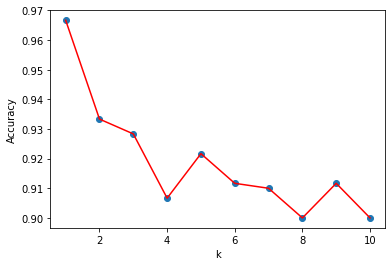

In [25]:
X_label = [x+1 for x in range(10)]
Y_label = list(range(10))
for num in range(10):
    clf = KNeighborsClassifier(n_neighbors = num+1)
    clf.fit(X_train, y_train)
    Y_pred = clf.predict(X_test)
    Y_label[num] = accuracy_score(y_test, Y_pred)
plt.scatter(X_label, Y_label)
plt.plot(X_label, Y_label, 'r-')
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.savefig('save/knn_binary_k_selection.png', bbox_inches='tight')
plt.show()

From the step above, K=1 is the best choice, which is not a common choice. Thus, the cross validation is employed here for second choice.
#### select the K by cross validation

In [37]:
k = [x+1 for x in range(10)]
train_accuracy, test_accuracy = validation_curve(
        KNeighborsClassifier(), X_scaled, Y_2,
        param_name = 'n_neighbors', param_range = k,
        cv=5, scoring='accuracy')
train_accuracy_mean = np.mean(train_accuracy, axis=1)
test_accuracy_mean = np.mean(test_accuracy, axis=1)

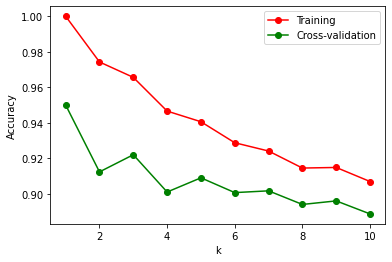

In [35]:
plt.plot(k, train_accuracy_mean, 'o-', color="r",
             label="Training")
plt.plot(k, test_accuracy_mean, 'o-', color="g",
             label="Cross-validation")

plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.savefig('save/knn_binary_k_selection_by_cv.png', bbox_inches='tight')
plt.show()

#### save the model

In [9]:
clf = KNeighborsClassifier(n_neighbors = 1)
clf.fit(X_train, y_train)
joblib.dump(clf, 'save/clf_knn_binary.pkl')

### 3.2.3 Random Forest
Random forest is a bagging integration algorithm. Using Bootstrap, it is noticed that about 1/3 of Bootstrap samples are used as out-of-bag data oob each time, thus random forest does not need to be cross-validated.

#### select the n_estimator/the number of trees in range (10, 200) every 10 steps.

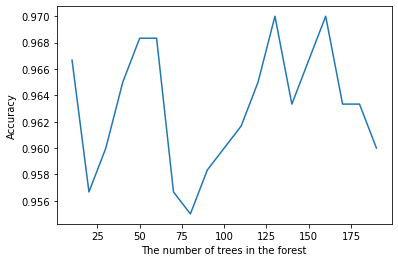

In [8]:
estimator = range(10,200,10)
accuracy = []

for n in estimator:
    clf = RandomForestClassifier(n_estimators = n)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores = accuracy_score(y_test,y_pred)
    accuracy.append(scores.mean())

plt.plot(estimator, accuracy)
plt.xlabel('The number of trees in the forest')
plt.ylabel('Accuracy')
plt.show()

In [9]:
accuracy_max = np.nanmax(accuracy)
# test_accuracy_mean = test_accuracy_mean.tolist()
print('Accuracy_max：{}'.format(accuracy_max),
      'n_estimators：{}'.format(accuracy.index(accuracy_max)*10+10))

Accuracy_max：0.97 n_estimators：130


The interval I choose to further select is (40, 60) since the variance in this interval is significantly less than (120, 140), and saving running time simultaneously.
#### select the n_estimator/the number of trees between 40 and 60

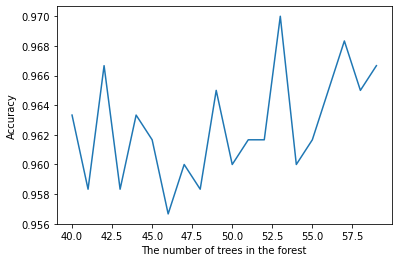

Accuracy_max：0.97 n_estimators：53


In [51]:
estimator = range(40,60)
accuracy = []
for n in estimator:
    clf = RandomForestClassifier(n_estimators = n)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores = accuracy_score(y_test,y_pred)
    accuracy.append(scores.mean())
plt.plot(estimator, accuracy)
plt.xlabel('The number of trees in the forest')
plt.ylabel('Accuracy')
plt.savefig('save/RF_Binary_estimator_40-60.png', bbox_inches='tight')
plt.show()
accuracy_max = np.nanmax(accuracy)
print('Accuracy_max：{}'.format(accuracy_max),
      'n_estimators：{}'.format(accuracy.index(accuracy_max)+40))

In [52]:
print(accuracy)

[0.9633333333333334, 0.9583333333333334, 0.9666666666666667, 0.9583333333333334, 0.9633333333333334, 0.9616666666666667, 0.9566666666666667, 0.96, 0.9583333333333334, 0.965, 0.96, 0.9616666666666667, 0.9616666666666667, 0.97, 0.96, 0.9616666666666667, 0.965, 0.9683333333333334, 0.965, 0.9666666666666667]


Thus, the hyper-parameter n_estimator is set as 53 in this work
#### select the min_samples_split in range(2, 202) every 10 steps
(The minimum number of samples required to split an internal node) 

In [55]:
min_samples_split = range(2,202,10)
accuracy = []

for n in min_samples_split:
    clf = RandomForestClassifier(n_estimators = 53, min_samples_split = n)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores = accuracy_score(y_test,y_pred)
    accuracy.append(scores.mean())

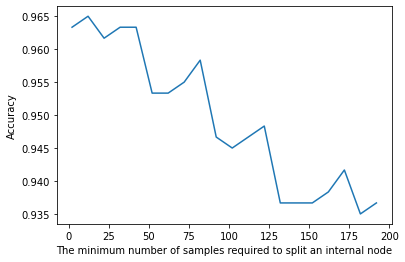

Accuracy_max：0.965 min_samples_split：12
[0.9633333333333334, 0.965, 0.9616666666666667, 0.9633333333333334, 0.9633333333333334, 0.9533333333333334, 0.9533333333333334, 0.955, 0.9583333333333334, 0.9466666666666667, 0.945, 0.9466666666666667, 0.9483333333333334, 0.9366666666666666, 0.9366666666666666, 0.9366666666666666, 0.9383333333333334, 0.9416666666666667, 0.935, 0.9366666666666666]


In [57]:
plt.plot(min_samples_split, accuracy)
plt.xlabel('The minimum number of samples required to split an internal node')
plt.ylabel('Accuracy')
plt.savefig('save/RF_Binary_minsample_2-202.png', bbox_inches='tight')
plt.show()
accuracy_max = np.nanmax(accuracy)
print('Accuracy_max：{}'.format(accuracy_max),
      'min_samples_split：{}'.format(accuracy.index(accuracy_max)*10+2))
print(accuracy)

In [58]:
min_samples_split = range(2,22,2)
accuracy = []

for n in min_samples_split:
    clf = RandomForestClassifier(n_estimators = 53, min_samples_split = n)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores = accuracy_score(y_test,y_pred)
    accuracy.append(scores.mean())

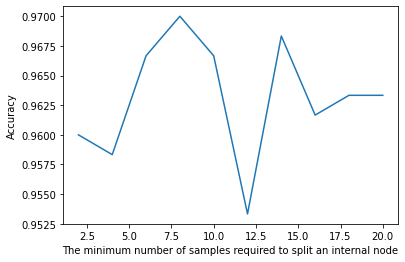

Accuracy_max：0.97 min_samples_split：8
[0.96, 0.9583333333333334, 0.9666666666666667, 0.97, 0.9666666666666667, 0.9533333333333334, 0.9683333333333334, 0.9616666666666667, 0.9633333333333334, 0.9633333333333334]


In [60]:
plt.plot(min_samples_split, accuracy)
plt.xlabel('The minimum number of samples required to split an internal node')
plt.ylabel('Accuracy')
plt.savefig('save/RF_Binary_minsample_2-22.png', bbox_inches='tight')
plt.show()
accuracy_max = np.nanmax(accuracy)
print('Accuracy_max：{}'.format(accuracy_max),
      'min_samples_split：{}'.format(accuracy.index(accuracy_max)*2+2))
print(accuracy)

Thus, min_sample_split is set as 8 in this work.

#### save the model

In [83]:
clf = RandomForestClassifier(n_estimators = 53, min_samples_split = 8)
clf.fit(X_train, y_train)
joblib.dump(clf, 'save/clf_RF_binary.pkl')

['save/clf_RF_binary.pkl']

# 4. Learning curve

### 4.1 KNN

In [66]:
from sklearn.model_selection import  learning_curve

model = [KNeighborsClassifier(n_neighbors = 1),
         RandomForestClassifier(n_estimators = 53, min_samples_split = 8),
         SVC(kernel = 'linear', C = 0.001, gamma = 0.0001)]

train_sizes, train_accuracy, test_accuracy= learning_curve(
        model[0], X_scaled, Y_2, cv=5, scoring='accuracy',
        train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
train_accuracy_mean = np.mean(train_accuracy, axis=1)
test_accuracy_mean = np.mean(test_accuracy, axis=1)

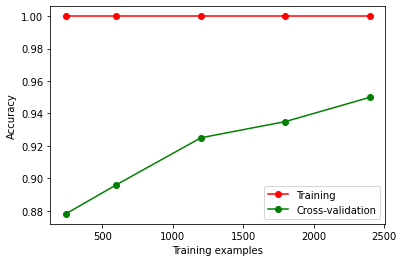

In [65]:
plt.plot(train_sizes, train_accuracy_mean, 'o-', color="r",
             label="Training")
plt.plot(train_sizes, test_accuracy_mean, 'o-', color="g",
             label="Cross-validation")

plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.savefig('save/KNN_learningcurve.png', bbox_inches='tight')
plt.show()

### 4.2 Random forest

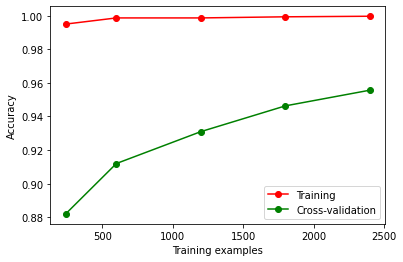

In [67]:
train_sizes, train_accuracy, test_accuracy= learning_curve(
        model[1], X_scaled, Y_2, cv=5, scoring='accuracy',
        train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
train_accuracy_mean = np.mean(train_accuracy, axis=1)
test_accuracy_mean = np.mean(test_accuracy, axis=1)
plt.plot(train_sizes, train_accuracy_mean, 'o-', color="r",
             label="Training")
plt.plot(train_sizes, test_accuracy_mean, 'o-', color="g",
             label="Cross-validation")

plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.savefig('save/RF_learningcurve.png', bbox_inches='tight')
plt.show()

### 4.3 SVM

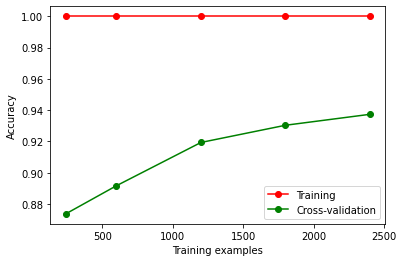

In [68]:
train_sizes, train_accuracy, test_accuracy= learning_curve(
        model[2], X_scaled, Y_2, cv=5, scoring='accuracy',
        train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
train_accuracy_mean = np.mean(train_accuracy, axis=1)
test_accuracy_mean = np.mean(test_accuracy, axis=1)
plt.plot(train_sizes, train_accuracy_mean, 'o-', color="r",
             label="Training")
plt.plot(train_sizes, test_accuracy_mean, 'o-', color="g",
             label="Cross-validation")

plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.savefig('save/SVM_learningcurve.png', bbox_inches='tight')
plt.show()